<a href="https://colab.research.google.com/gist/MBSaravanaBalaji/93d1e46ef6228cc89c1dd08fd2ee9d97/chicago.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Safest location (lat, lon): (41.657321469, -87.905227221)
Most dangerous location (lat, lon): (41.8896361849799, -87.63026694409547)
Safest hour (time): 4
Most dangerous hour (time): 23


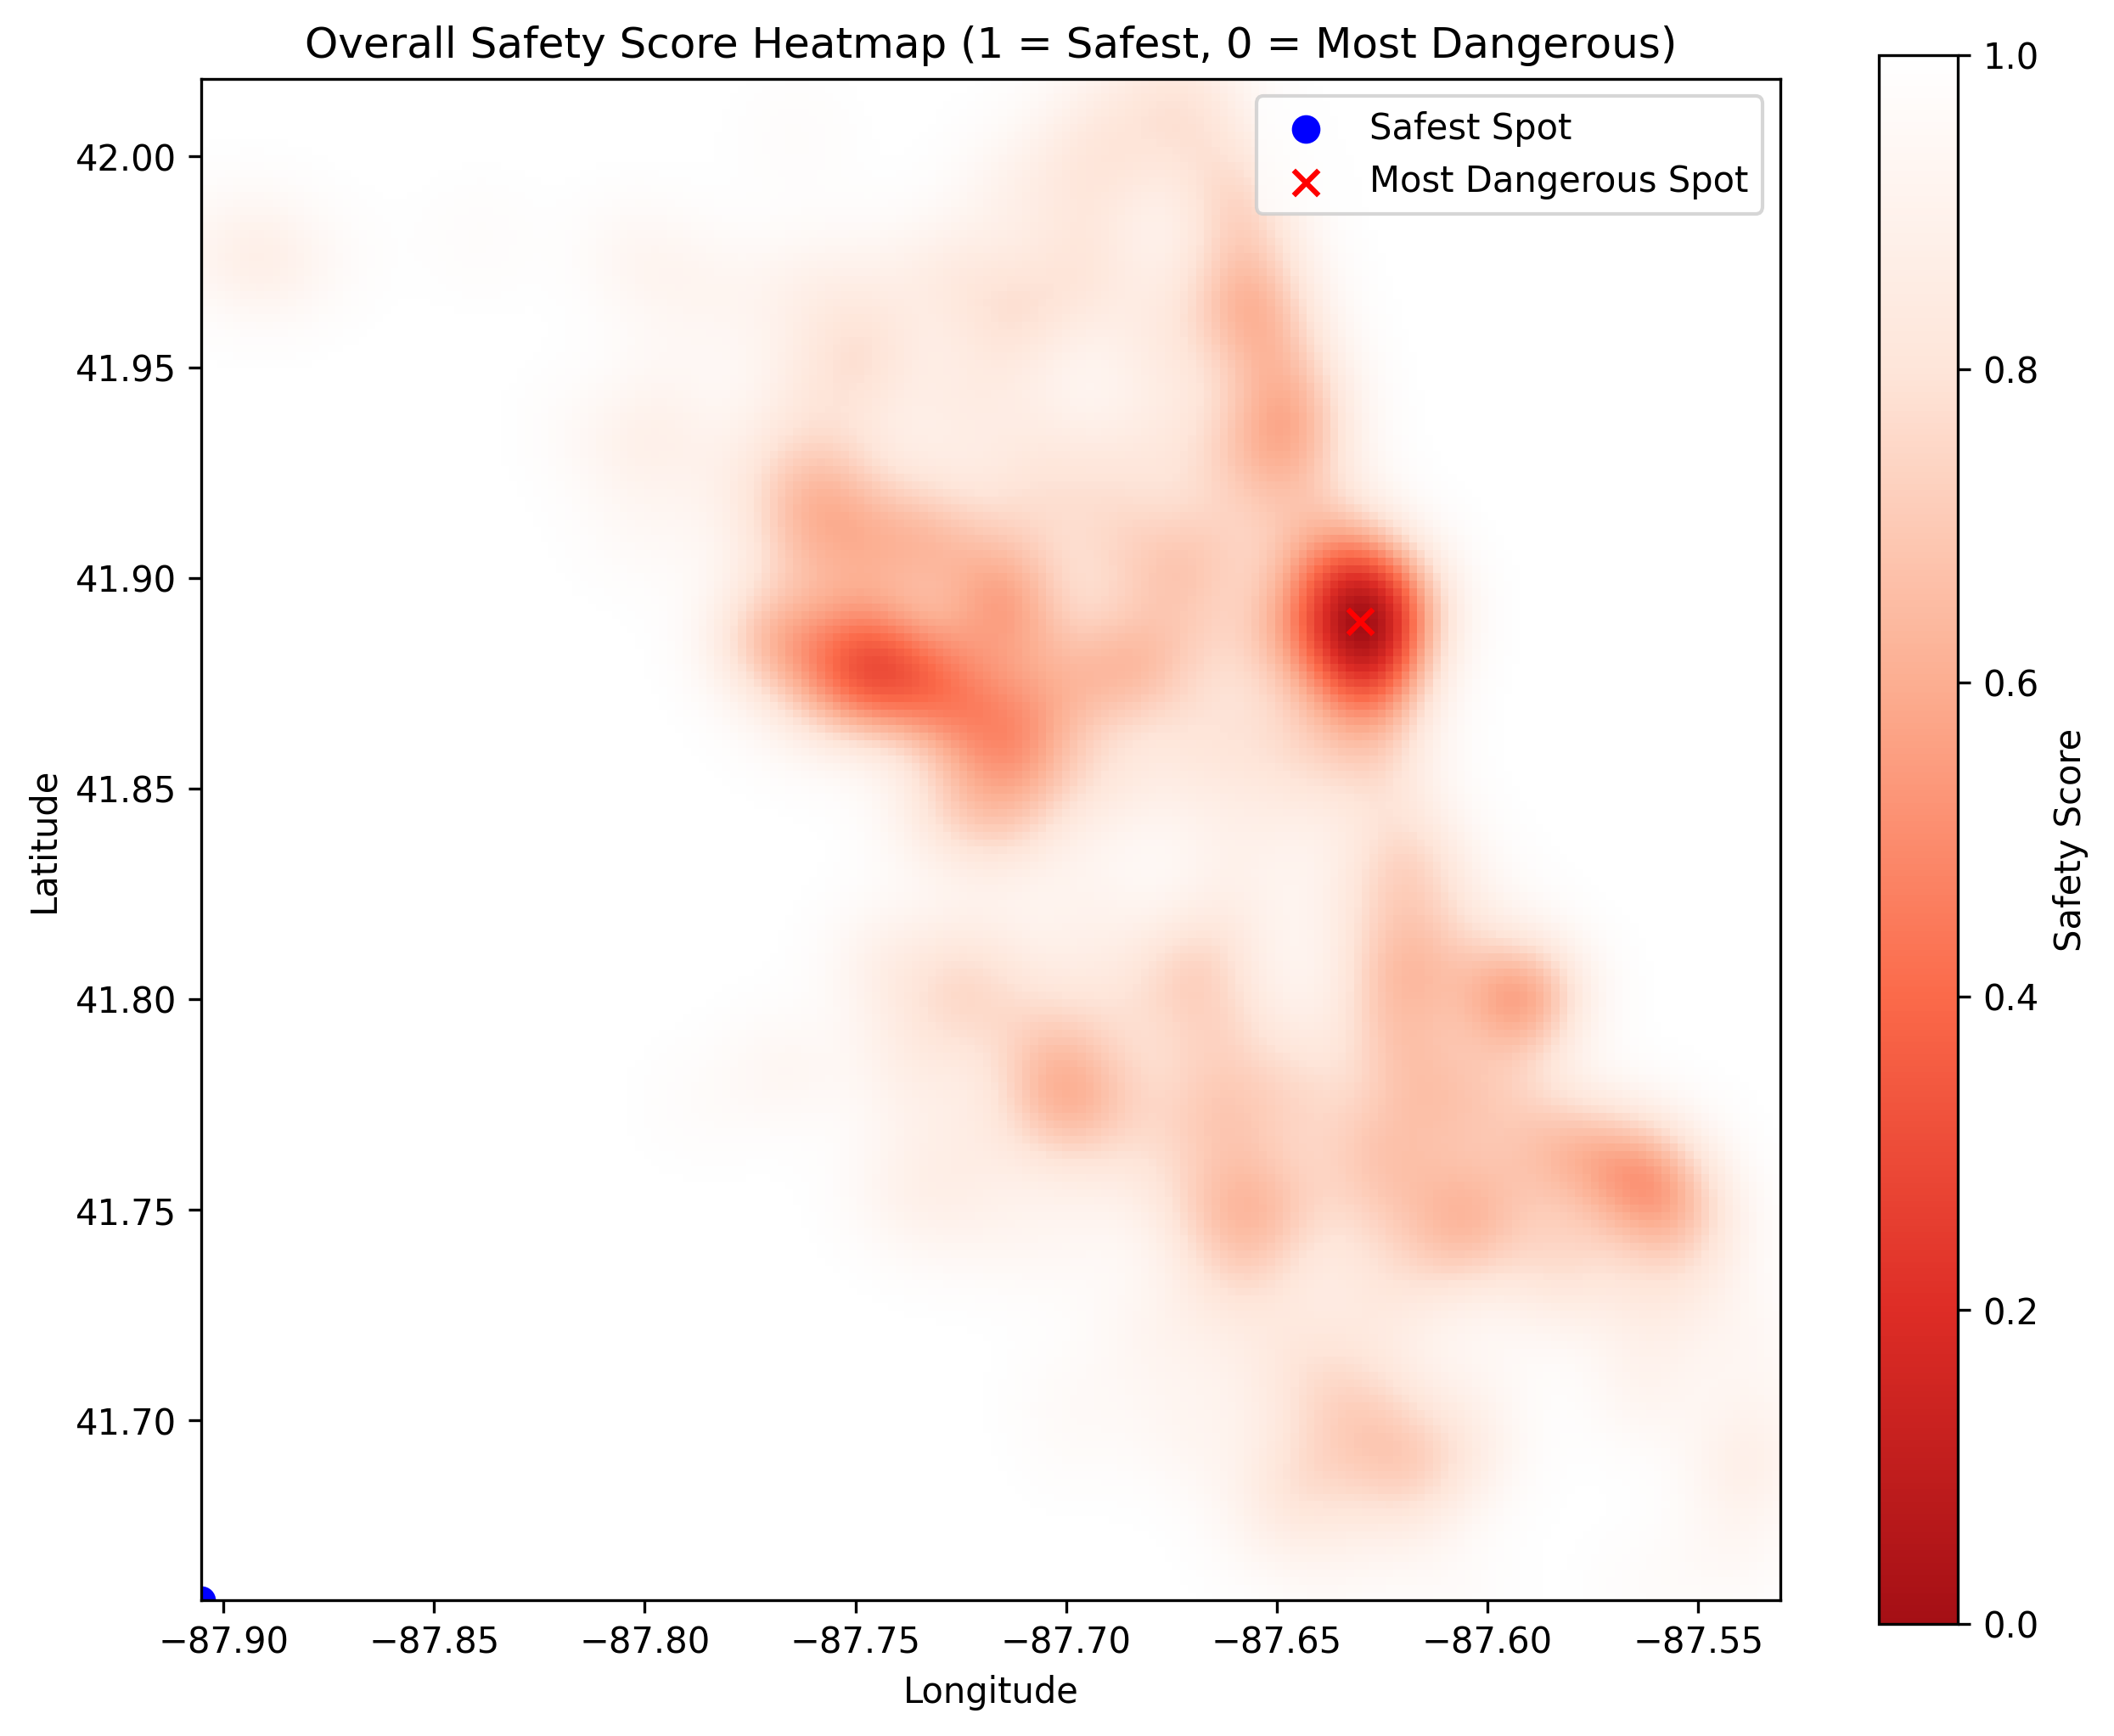

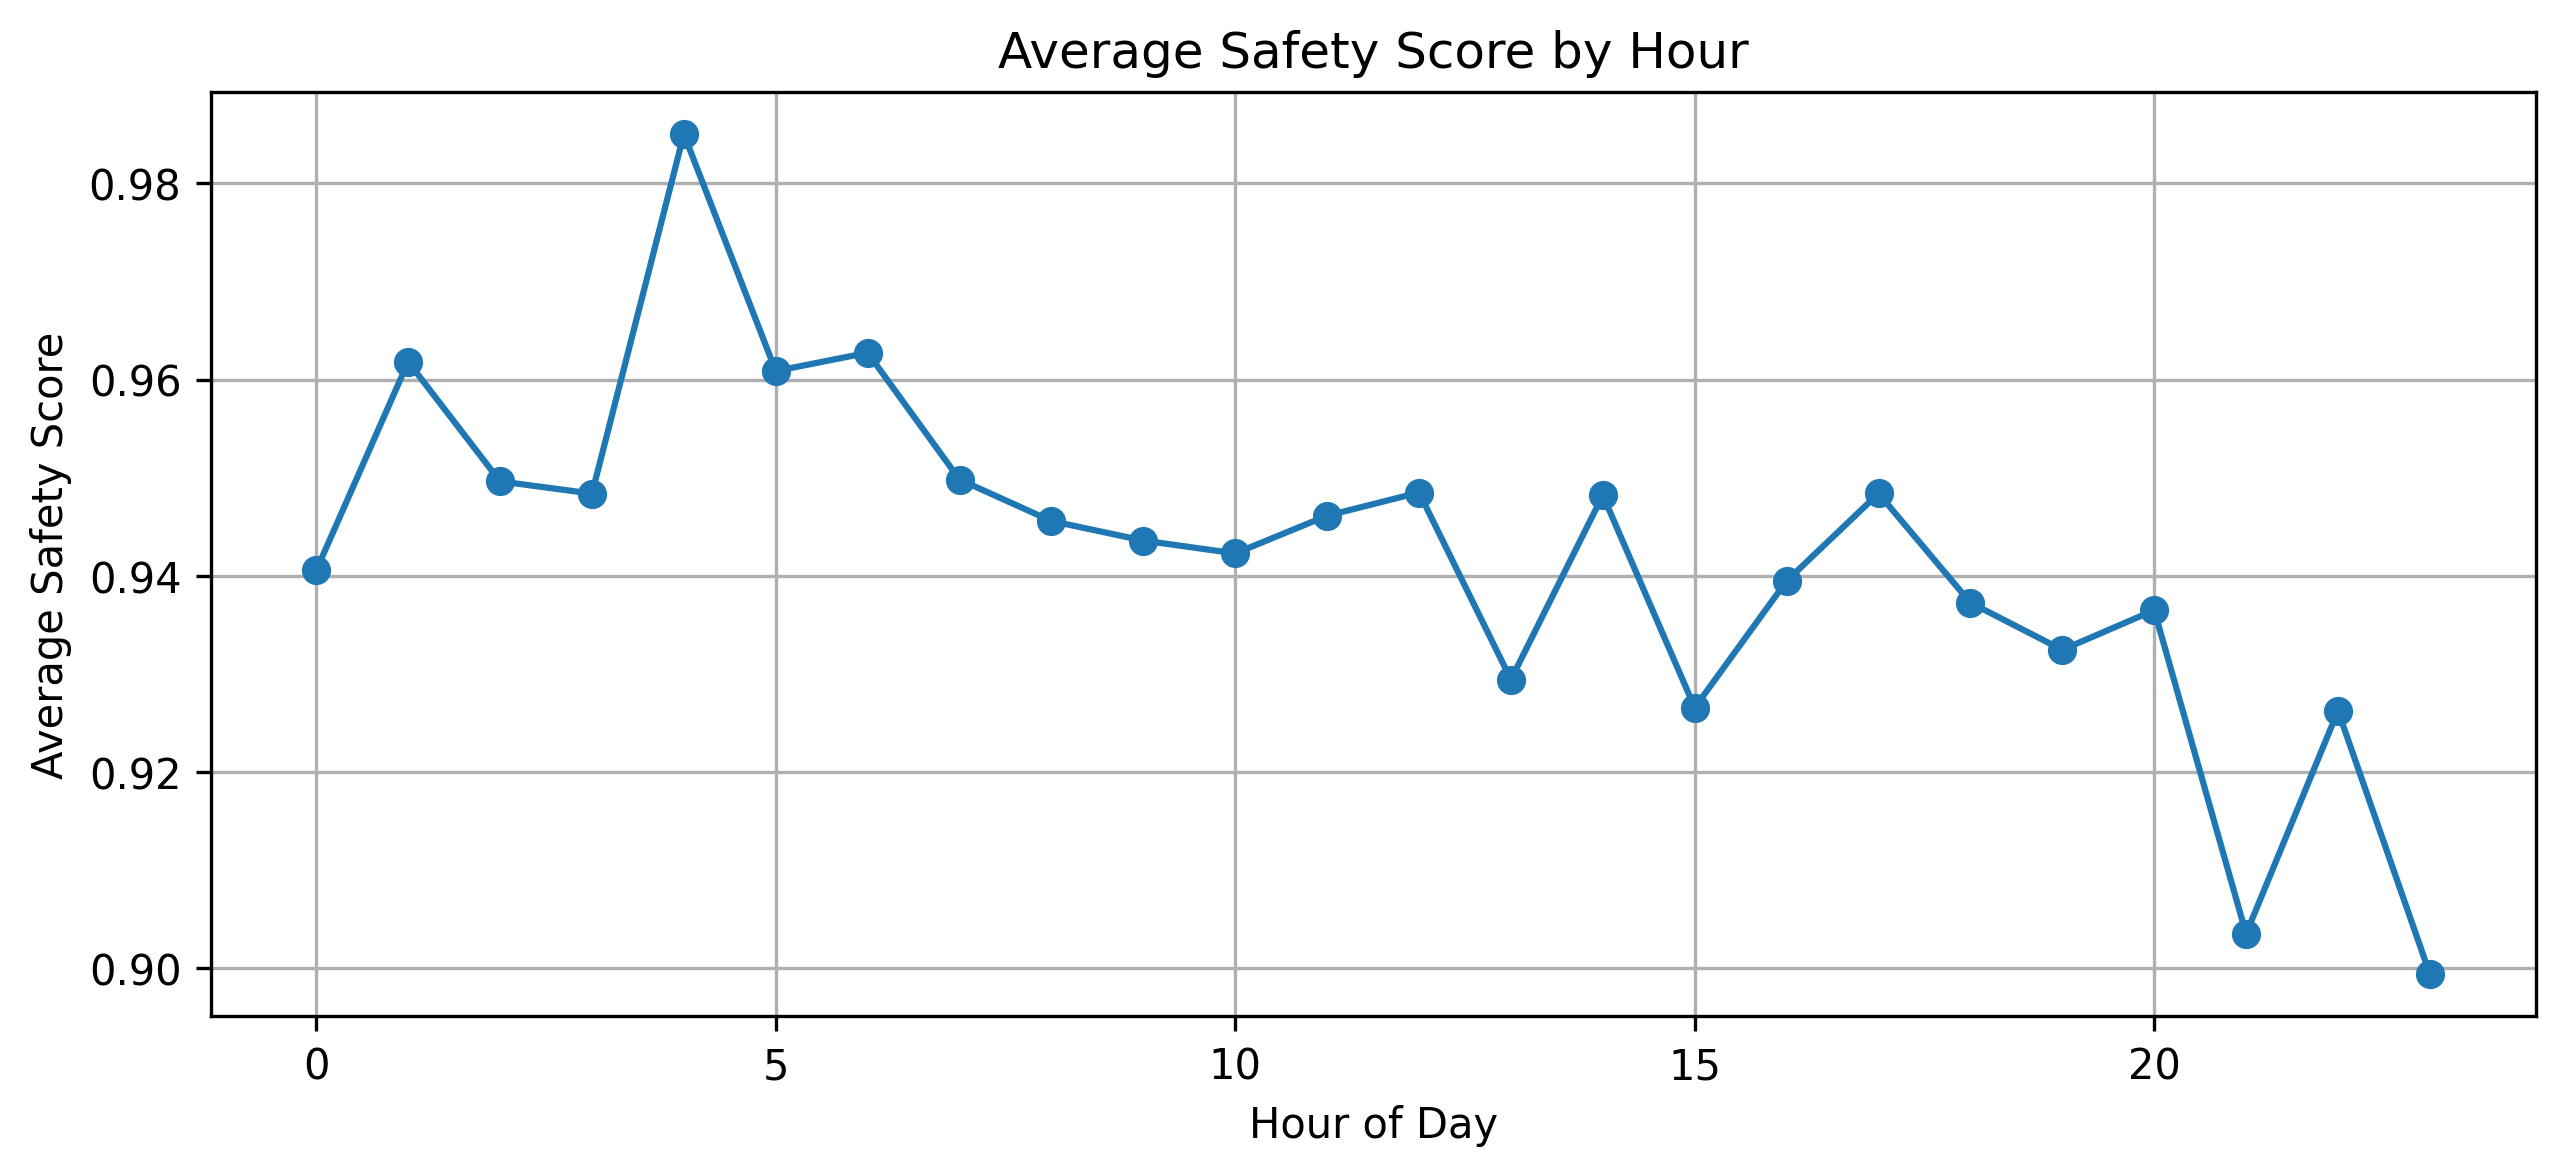

In [ ]:
import pandas as pd
import numpy as np
from sklearn.neighbors import KernelDensity
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap


df = pd.read_json('ijzp-q8t2.json')


df['date'] = pd.to_datetime(df['date'])
df['hour'] = df['date'].dt.hour


df = df.dropna(subset=['latitude', 'longitude'])


coords = df[['latitude', 'longitude']].values


kde = KernelDensity(bandwidth=0.01, kernel='gaussian')
kde.fit(coords)

n_points = 200
lon_min, lon_max = df['longitude'].min(), df['longitude'].max()
lat_min, lat_max = df['latitude'].min(), df['latitude'].max()
lon_lin = np.linspace(lon_min, lon_max, n_points)
lat_lin = np.linspace(lat_min, lat_max, n_points)
lon_grid, lat_grid = np.meshgrid(lon_lin, lat_lin)
grid_coords = np.vstack([lat_grid.ravel(), lon_grid.ravel()]).T


log_density = kde.score_samples(grid_coords)
density = np.exp(log_density).reshape(lon_grid.shape)
norm_density = (density - density.min()) / (density.max() - density.min())

# Compute the "safety score" (higher = safer, i.e. lower density)
safety_score = 1 - norm_density

# Find grid cell indices of the safest and most dangerous spots
max_idx = np.unravel_index(np.argmax(safety_score), safety_score.shape)
min_idx = np.unravel_index(np.argmin(safety_score), safety_score.shape)
safest_location = (lat_grid[max_idx], lon_grid[max_idx])
most_dangerous_location = (lat_grid[min_idx], lon_grid[min_idx])
print("Safest location (lat, lon):", safest_location)
print("Most dangerous location (lat, lon):", most_dangerous_location)

# ------------------------------
# Time Analysis: Safety by Hour
# ------------------------------

hour_safety = {}
for h in sorted(df['hour'].unique()):
    df_hour = df[df['hour'] == h]
    if len(df_hour) < 5:
        continue
    coords_h = df_hour[['latitude', 'longitude']].values
    kde_h = KernelDensity(bandwidth=0.01, kernel='gaussian')
    kde_h.fit(coords_h)
    log_density_h = kde_h.score_samples(grid_coords)
    density_h = np.exp(log_density_h).reshape(lon_grid.shape)
    norm_density_h = (density_h - density_h.min()) / (density_h.max() - density_h.min())
    safety_score_h = 1 - norm_density_h
    avg_safety = np.mean(safety_score_h)
    hour_safety[h] = avg_safety

safest_time = max(hour_safety, key=hour_safety.get)
most_dangerous_time = min(hour_safety, key=hour_safety.get)
print("Safest hour (time):", safest_time)
print("Most dangerous hour (time):", most_dangerous_time)

# ------------------------------
# Visualization
# ------------------------------

# Reverse the white->red list so that the first color (lowest safety) is red
my_colors = [
    '#a50f15',  # deep red (for the most dangerous / lowest safety)
    '#de2d26',
    '#fb6a4a',
    '#fcae91',
    '#fee5d9',
    '#ffffff'   # white (for the safest / highest safety)
]
custom_reds = LinearSegmentedColormap.from_list('custom_reds', my_colors, N=256)

# Plot overall safety score heatmap
plt.figure(figsize=(10, 8), dpi=300)
plt.imshow(
    safety_score,
    extent=(lon_min, lon_max, lat_min, lat_max),
    origin='lower',
    cmap=custom_reds
)
plt.title('Overall Safety Score Heatmap (1 = Safest, 0 = Most Dangerous)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.colorbar(label='Safety Score')
plt.scatter(
    [safest_location[1]],
    [safest_location[0]],
    color='blue', marker='o', s=50, label='Safest Spot'
)
plt.scatter(
    [most_dangerous_location[1]],
    [most_dangerous_location[0]],
    color='red', marker='x', s=50, label='Most Dangerous Spot'
)
plt.legend()
plt.show()

# Plot average safety score by hour
plt.figure(figsize=(10, 4), dpi=300)
plt.plot(list(hour_safety.keys()), list(hour_safety.values()), marker='o', linestyle='-')
plt.xlabel('Hour of Day')
plt.ylabel('Average Safety Score')
plt.title('Average Safety Score by Hour')
plt.grid(True)
plt.show()


Most dangerous location (lat, lon): (41.8896361849799, -87.63026694409547)

Hourly Safety Score at the Most Dangerous Location:
    Hour  Safety Score (1-100)
0      0             57.798312
1      1             20.951774
2      2             99.997020
3      3             99.999990
4      4            100.000000
5      5             89.844453
6      6             78.731750
7      7              1.857092
8      8             15.809720
9      9             25.725953
10    10             15.774234
11    11             42.609685
12    12             64.351268
13    13             30.018085
14    14              4.109724
15    15             34.843627
16    16             16.051919
17    17             11.102909
18    18              6.328843
19    19             20.559536
20    20             74.335646
21    21             16.693485
22    22             27.560791
23    23             42.733419

Safest hour at that location: 4
Most dangerous hour at that location: 7


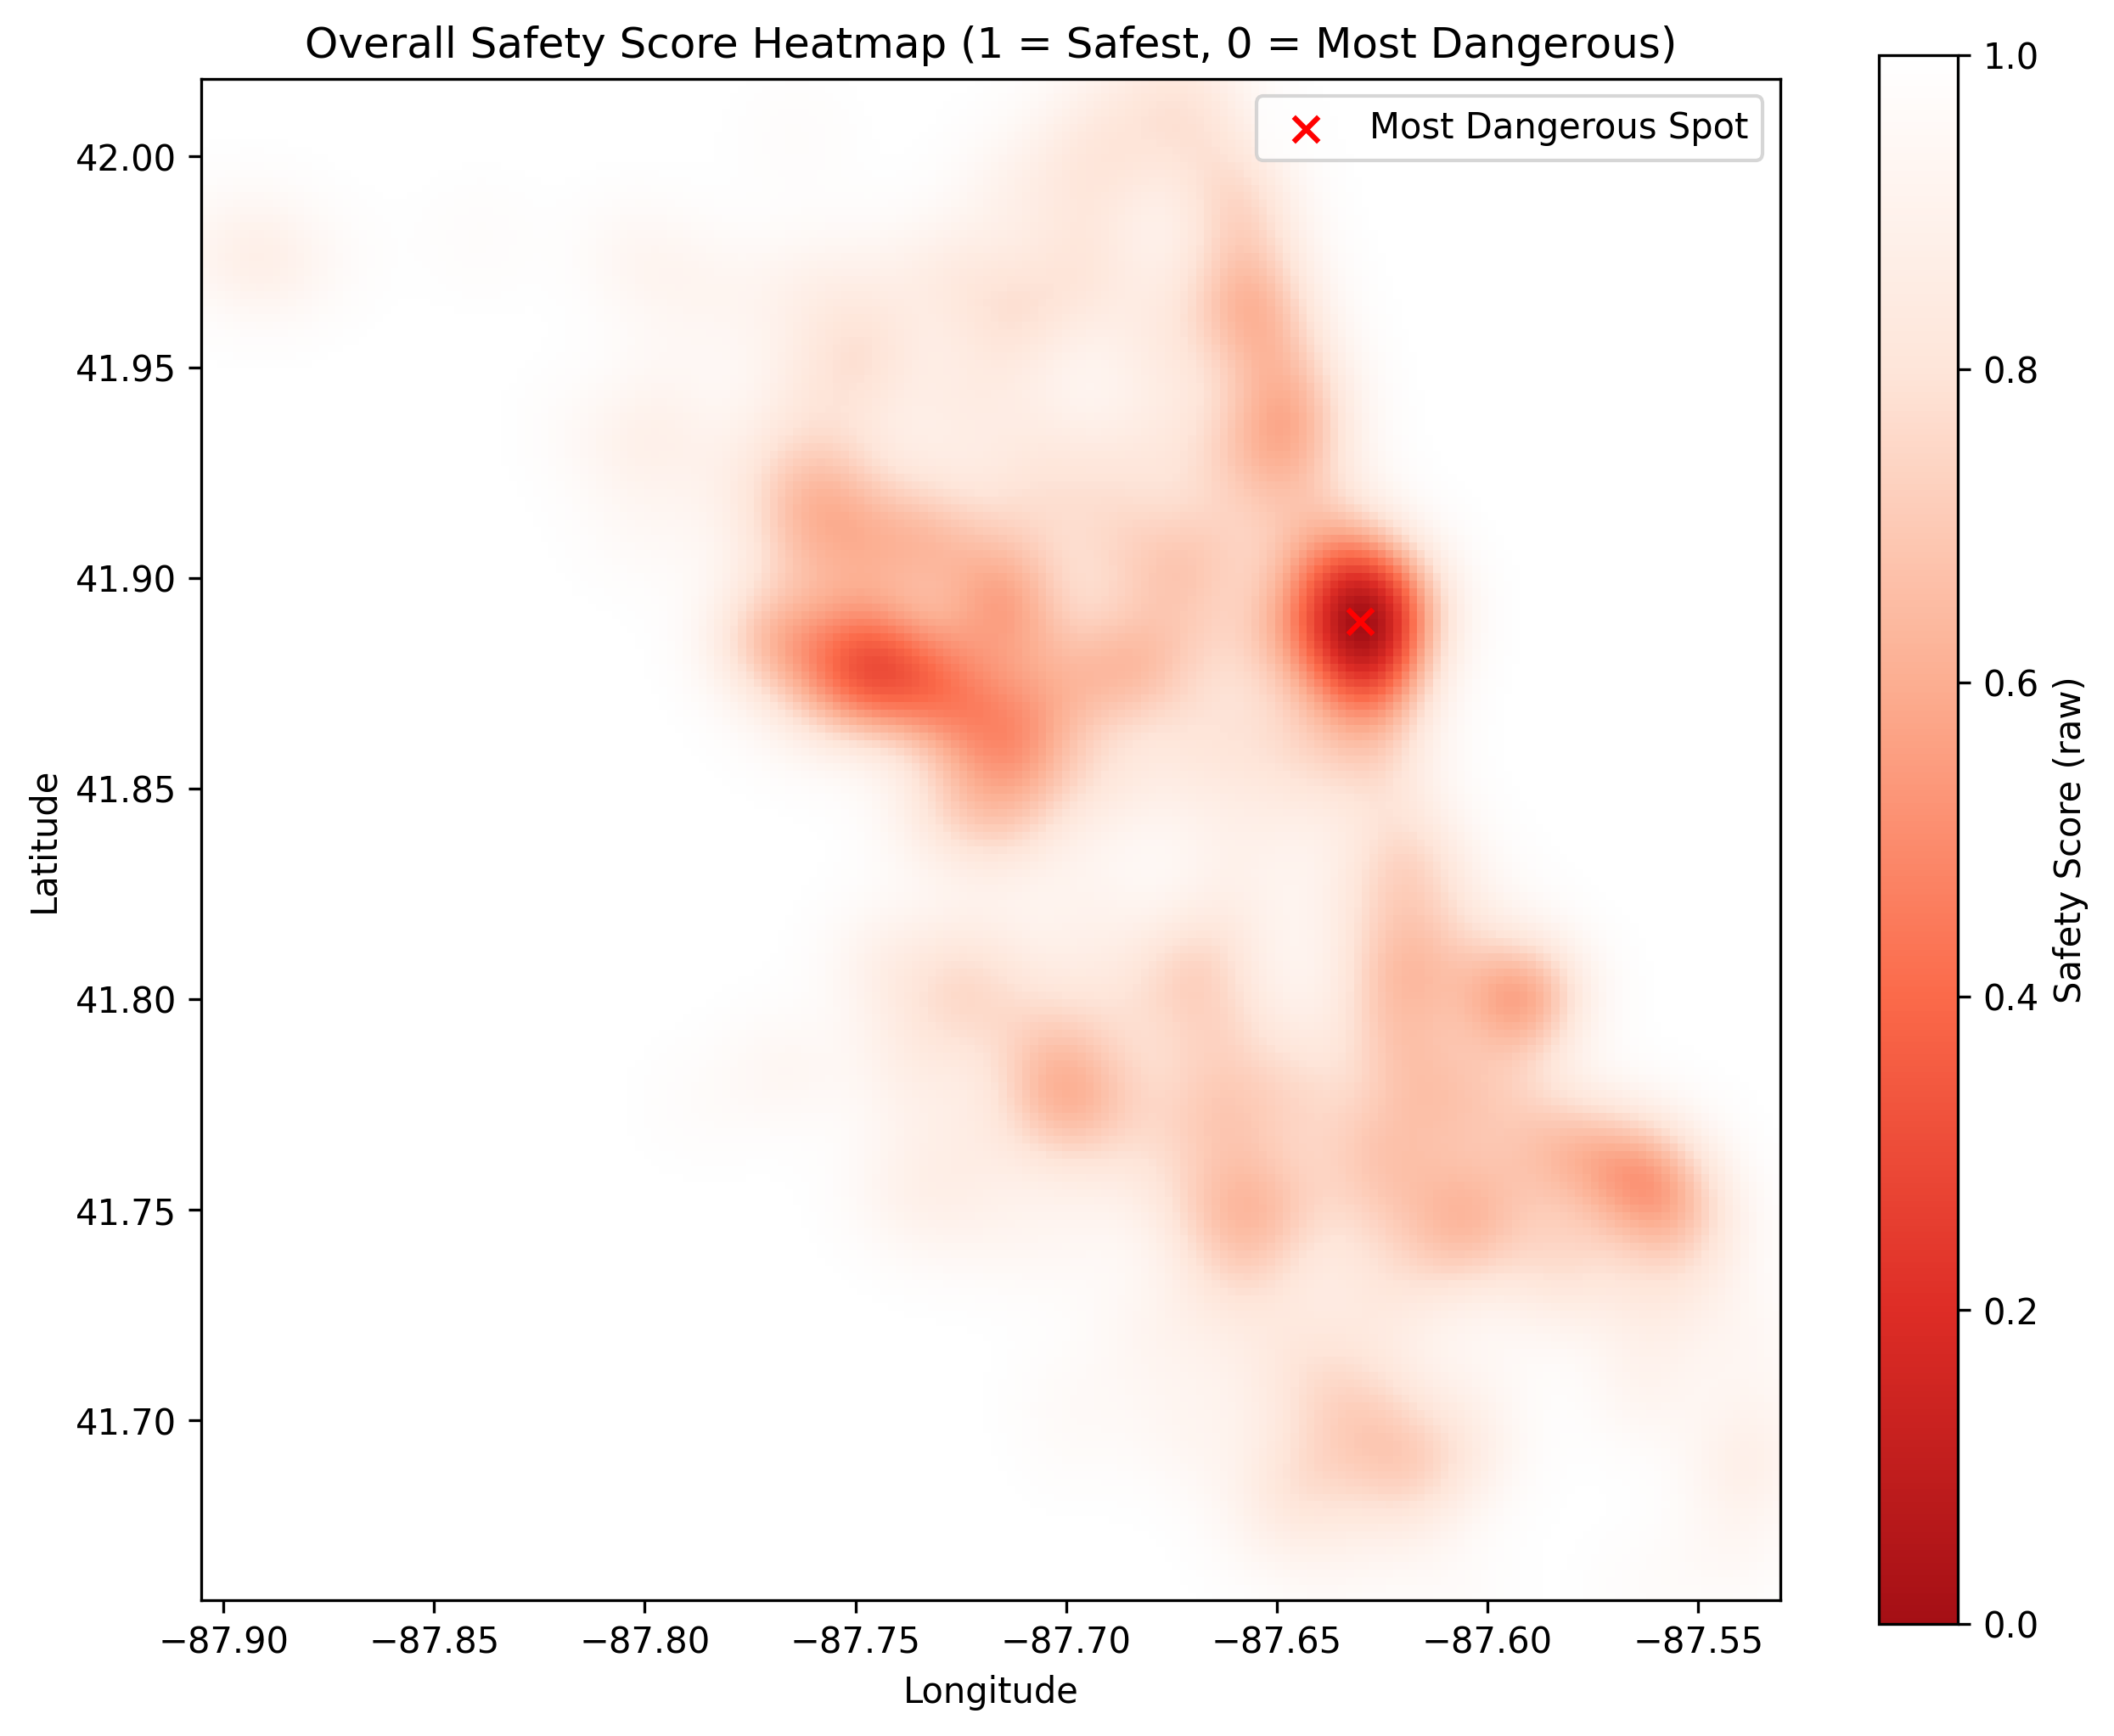

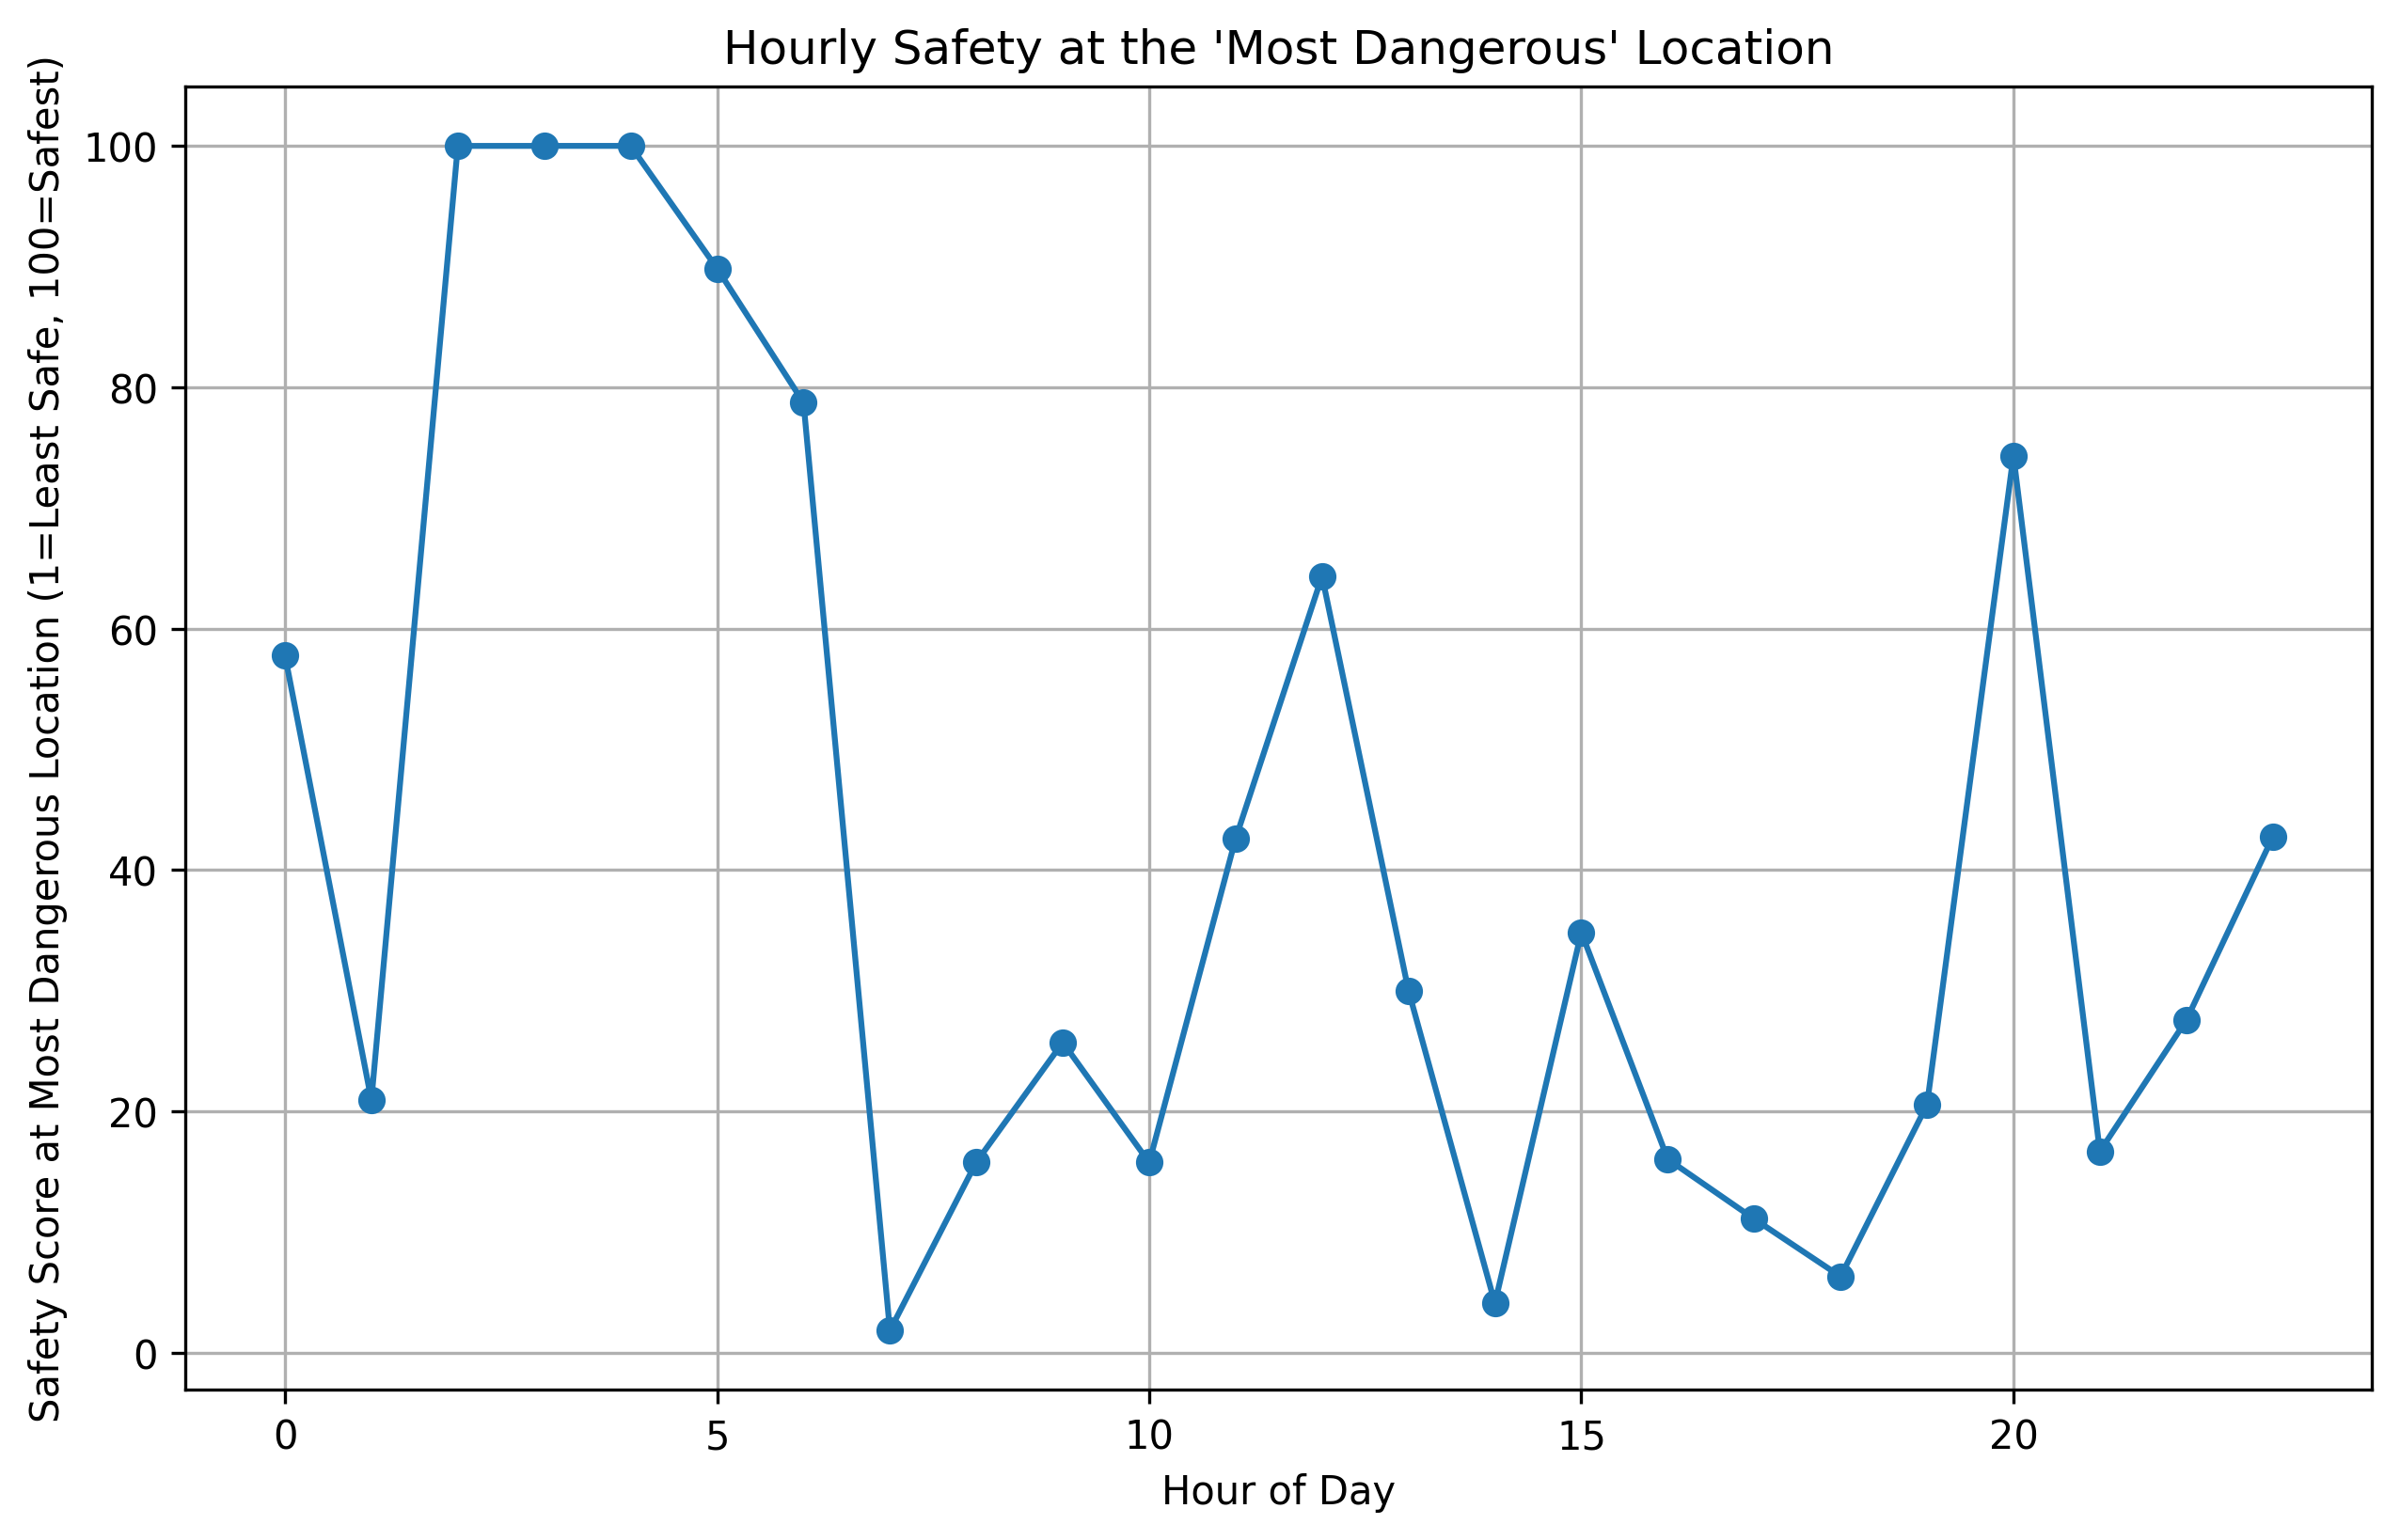

In [2]:
import pandas as pd
import numpy as np
from sklearn.neighbors import KernelDensity
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

# ------------------------------
# 1. Load and Preprocess Data
# ------------------------------
df = pd.read_json('ijzp-q8t2.json')

# Convert the 'date' column to datetime and extract the hour
df['date'] = pd.to_datetime(df['date'])
df['hour'] = df['date'].dt.hour

# Drop rows with missing latitude or longitude values
df = df.dropna(subset=['latitude', 'longitude'])

# ------------------------------
# 2. Overall Spatial Safety Score & Heatmap
# ------------------------------
# Extract all coordinates
coords = df[['latitude', 'longitude']].values

# Fit a KDE model on all points
kde_all = KernelDensity(bandwidth=0.01, kernel='gaussian')
kde_all.fit(coords)

# Create a grid over the bounding box
n_points = 200
lon_min, lon_max = df['longitude'].min(), df['longitude'].max()
lat_min, lat_max = df['latitude'].min(), df['latitude'].max()
lon_lin = np.linspace(lon_min, lon_max, n_points)
lat_lin = np.linspace(lat_min, lat_max, n_points)
lon_grid, lat_grid = np.meshgrid(lon_lin, lat_lin)
grid_coords = np.vstack([lat_grid.ravel(), lon_grid.ravel()]).T

# Evaluate density on grid and compute "raw safety" (1 - normalized density)
log_density_all = kde_all.score_samples(grid_coords)
density_all = np.exp(log_density_all).reshape(lon_grid.shape)
norm_density_all = (density_all - density_all.min()) / (density_all.max() - density_all.min())
safety_score_all = 1 - norm_density_all  # Higher => Safer

# Find the grid cell with the lowest safety score (i.e. most dangerous)
min_idx = np.unravel_index(np.argmin(safety_score_all), safety_score_all.shape)
most_dangerous_location = (lat_grid[min_idx], lon_grid[min_idx])
print("Most dangerous location (lat, lon):", most_dangerous_location)

# ------------------------------
# 3. Hourly Safety Score at the Most Dangerous Location
# ------------------------------
hour_safety_at_dangerous = {}

# For each hour, fit a KDE to that hour's data and compute the safety at the given location.
for h in sorted(df['hour'].unique()):
    df_hour = df[df['hour'] == h]
    # Skip hours with too few points
    if len(df_hour) < 5:
        continue

    coords_h = df_hour[['latitude', 'longitude']].values
    kde_h = KernelDensity(bandwidth=0.01, kernel='gaussian')
    kde_h.fit(coords_h)

    # Evaluate density over the grid for hour h (for normalization)
    log_density_h = kde_h.score_samples(grid_coords)
    density_h = np.exp(log_density_h).reshape(lon_grid.shape)
    dmin, dmax = density_h.min(), density_h.max()

    # Evaluate density at the most dangerous location
    loc = np.array([[most_dangerous_location[0], most_dangerous_location[1]]])
    log_density_loc = kde_h.score_samples(loc)
    density_loc = np.exp(log_density_loc)[0]

    # Normalize the density at that location using this hour's min and max
    if dmax > dmin:
        norm_loc = (density_loc - dmin) / (dmax - dmin)
    else:
        norm_loc = 0.5  # fallback in unlikely event of no variation

    # Raw safety: 1 - normalized density (so lower density => higher safety)
    raw_safety = 1 - norm_loc

    # Scale to 1-100: if raw_safety=0 then score=1, if raw_safety=1 then score=100
    scaled_safety = 1 + raw_safety * 99
    hour_safety_at_dangerous[h] = scaled_safety

# Convert results to a DataFrame for easier viewing
hour_safety_df = pd.DataFrame(list(hour_safety_at_dangerous.items()),
                              columns=['Hour', 'Safety Score (1-100)']).sort_values('Hour')
print("\nHourly Safety Score at the Most Dangerous Location:")
print(hour_safety_df)

# Identify which hour is "safest" (highest score) and "most dangerous" (lowest score)
safest_hour = hour_safety_df.loc[hour_safety_df['Safety Score (1-100)'].idxmax(), 'Hour']
most_dangerous_hour = hour_safety_df.loc[hour_safety_df['Safety Score (1-100)'].idxmin(), 'Hour']
print("\nSafest hour at that location:", safest_hour)
print("Most dangerous hour at that location:", most_dangerous_hour)

# ------------------------------
# 4. Visualization
# ------------------------------

# (A) Heatmap of Overall Safety Score
my_colors = [
    '#a50f15',  # deep red (most dangerous)
    '#de2d26',
    '#fb6a4a',
    '#fcae91',
    '#fee5d9',
    '#ffffff'   # white (safest)
]
custom_reds = LinearSegmentedColormap.from_list('custom_reds', my_colors, N=256)

plt.figure(figsize=(10, 8), dpi=300)
plt.imshow(
    safety_score_all,
    extent=(lon_min, lon_max, lat_min, lat_max),
    origin='lower',
    cmap=custom_reds
)
plt.title('Overall Safety Score Heatmap (1 = Safest, 0 = Most Dangerous)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.colorbar(label='Safety Score (raw)')
plt.scatter([most_dangerous_location[1]], [most_dangerous_location[0]],
            color='red', marker='x', s=50, label='Most Dangerous Spot')
plt.legend()
plt.show()

# (B) Hourly Safety Score at the Most Dangerous Location (Line Plot & Table)
fig, ax = plt.subplots(figsize=(10, 6), dpi=300)

# Line plot
ax.plot(hour_safety_df['Hour'], hour_safety_df['Safety Score (1-100)'],
        marker='o', linestyle='-')
ax.set_xlabel('Hour of Day')
ax.set_ylabel('Safety Score at Most Dangerous Location (1=Least Safe, 100=Safest)')
ax.set_title("Hourly Safety at the 'Most Dangerous' Location")
ax.grid(True)

# # Add table below the plot
# table = plt.table(cellText=hour_safety_df.values,
#                   colLabels=hour_safety_df.columns,
#                   loc='bottom',
#                   cellLoc='center')
# plt.subplots_adjust(left=0.2, bottom=0.3)
# plt.show()